<a href="https://colab.research.google.com/github/Sp-supriya/HCDS-Projects/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ***Housekeeping Management System in the Hospitality Industry ***

In [ ]:
from datetime import datetime, timedelta
from enum import Enum
import sqlite3
import random

class RoomStatus(Enum):
    VACANT_CLEAN = "Vacant Clean"
    VACANT_DIRTY = "Vacant Dirty"
    OCCUPIED_CLEAN = "Occupied Clean"
    OCCUPIED_DIRTY = "Occupied Dirty"
    OUT_OF_ORDER = "Out of Order"
    DUE_OUT = "Due Out"

class Priority(Enum):
    HIGH = "High"
    MEDIUM = "Medium"
    LOW = "Low"

class HousekeepingSystem:
    def __init__(self, db_name="housekeeping.db"):
        self.conn = sqlite3.connect(db_name)
        self.create_tables()

    def create_tables(self):
        cursor = self.conn.cursor()

        # Rooms table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS rooms (
            room_number TEXT PRIMARY KEY,
            room_type TEXT,
            status TEXT,
            last_cleaned DATETIME,
            notes TEXT
        )''')

        # Staff table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS staff (
            id INTEGER PRIMARY KEY,
            name TEXT,
            position TEXT,
            shift TEXT,
            contact TEXT
        )''')

        # Assignments table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS assignments (
            id INTEGER PRIMARY KEY,
            room_number TEXT,
            staff_id INTEGER,
            assignment_date DATE,
            status TEXT,
            priority TEXT,
            FOREIGN KEY (room_number) REFERENCES rooms (room_number),
            FOREIGN KEY (staff_id) REFERENCES staff (id)
        )''')

        # Inventory table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS inventory (
            id INTEGER PRIMARY KEY,
            item_name TEXT,
            quantity INTEGER,
            reorder_level INTEGER,
            last_restocked DATE
        )''')

        self.conn.commit()

    def add_room(self, room_number, room_type, status=RoomStatus.VACANT_CLEAN.value):
        cursor = self.conn.cursor()
        cursor.execute('''
        INSERT INTO rooms (room_number, room_type, status, last_cleaned)
        VALUES (?, ?, ?, ?)
        ''', (room_number, room_type, status, datetime.now()))
        self.conn.commit()

    def update_room_status(self, room_number, new_status):
        if not isinstance(new_status, RoomStatus):
            raise ValueError("Invalid room status")

        cursor = self.conn.cursor()
        cursor.execute('''
        UPDATE rooms
        SET status = ?, last_cleaned = ?
        WHERE room_number = ?
        ''', (new_status.value, datetime.now(), room_number))
        self.conn.commit()

    def add_staff(self, name, position, shift, contact):
        cursor = self.conn.cursor()
        cursor.execute('''
        INSERT INTO staff (name, position, shift, contact)
        VALUES (?, ?, ?, ?)
        ''', (name, position, shift, contact))
        self.conn.commit()

    def create_assignment(self, room_number, staff_id, priority=Priority.MEDIUM.value):
        cursor = self.conn.cursor()
        cursor.execute('''
        INSERT INTO assignments (room_number, staff_id, assignment_date, status, priority)
        VALUES (?, ?, ?, ?, ?)
        ''', (room_number, staff_id, datetime.now(), "Pending", priority))
        self.conn.commit()

    def update_inventory(self, item_name, quantity, reorder_level):
        cursor = self.conn.cursor()
        cursor.execute('''
        INSERT OR REPLACE INTO inventory (item_name, quantity, reorder_level, last_restocked)
        VALUES (?, ?, ?, ?)
        ''', (item_name, quantity, reorder_level, datetime.now()))
        self.conn.commit()

    def get_room_status(self, room_number):
        cursor = self.conn.cursor()
        cursor.execute('SELECT status FROM rooms WHERE room_number = ?', (room_number,))
        return cursor.fetchone()[0]

    def get_staff_assignments(self, staff_id):
        cursor = self.conn.cursor()
        cursor.execute('''
        SELECT r.room_number, r.room_type, a.priority, a.status
        FROM assignments a
        JOIN rooms r ON a.room_number = r.room_number
        WHERE a.staff_id = ? AND a.assignment_date = DATE('now')
        ''', (staff_id,))
        return cursor.fetchall()

    def check_inventory_levels(self):
        cursor = self.conn.cursor()
        cursor.execute('''
        SELECT item_name, quantity, reorder_level
        FROM inventory
        WHERE quantity <= reorder_level
        ''')
        return cursor.fetchall()

    def generate_daily_report(self):
        cursor = self.conn.cursor()
        report = {
            "total_rooms": 0,
            "vacant_clean": 0,
            "vacant_dirty": 0,
            "occupied_clean": 0,
            "occupied_dirty": 0,
            "out_of_order": 0,
            "due_out": 0,
            "assignments_completed": 0,
            "assignments_pending": 0
        }

        # Room statistics
        cursor.execute('SELECT status, COUNT(*) FROM rooms GROUP BY status')
        for status, count in cursor.fetchall():
            report["total_rooms"] += count
            if status == RoomStatus.VACANT_CLEAN.value:
                report["vacant_clean"] = count
            elif status == RoomStatus.VACANT_DIRTY.value:
                report["vacant_dirty"] = count
            elif status == RoomStatus.OCCUPIED_CLEAN.value:
                report["occupied_clean"] = count
            elif status == RoomStatus.OCCUPIED_DIRTY.value:
                report["occupied_dirty"] = count
            elif status == RoomStatus.OUT_OF_ORDER.value:
                report["out_of_order"] = count
            elif status == RoomStatus.DUE_OUT.value:
                report["due_out"] = count

        # Assignment statistics
        cursor.execute('''
        SELECT status, COUNT(*)
        FROM assignments
        WHERE assignment_date = DATE('now')
        GROUP BY status
        ''')
        for status, count in cursor.fetchall():
            if status == "Completed":
                report["assignments_completed"] = count
            elif status == "Pending":
                report["assignments_pending"] = count

        return report

    def optimize_assignments(self):
        """Optimize room assignments based on priority and staff availability"""
        cursor = self.conn.cursor()

        # Get all available staff
        cursor.execute('SELECT id FROM staff WHERE shift = ?',
                      (self.get_current_shift(),))
        available_staff = cursor.fetchall()

        # Get rooms that need cleaning
        cursor.execute('''
        SELECT room_number
        FROM rooms
        WHERE status IN (?, ?, ?)
        ''', (RoomStatus.VACANT_DIRTY.value,
              RoomStatus.OCCUPIED_DIRTY.value,
              RoomStatus.DUE_OUT.value))
        dirty_rooms = cursor.fetchall()

        # Simple round-robin assignment
        if available_staff and dirty_rooms:
            for i, room in enumerate(dirty_rooms):
                staff_id = available_staff[i % len(available_staff)][0]
                priority = Priority.HIGH.value if self.get_room_status(room[0]) == RoomStatus.DUE_OUT.value \
                    else Priority.MEDIUM.value
                self.create_assignment(room[0], staff_id, priority)

    def get_current_shift(self):
        """Determine current shift based on time of day"""
        hour = datetime.now().hour
        if 7 <= hour < 15:
            return "Morning"
        elif 15 <= hour < 23:
            return "Evening"
        else:
            return "Night"

    def close_connection(self):
        self.conn.close()

# Example usage
def main():
    system = HousekeepingSystem()

    # Add some sample data
    system.add_room("101", "Single")
    system.add_room("102", "Double")
    system.add_staff("John Doe", "Housekeeper", "Morning", "555-0101")
    system.add_staff("Jane Smith", "Supervisor", "Morning", "555-0102")

    # Update room status
    system.update_room_status("101", RoomStatus.OCCUPIED_DIRTY)

    # Create assignments
    system.create_assignment("101", 1, Priority.HIGH.value)

    # Update inventory
    system.update_inventory("Towels", 100, 50)
    system.update_inventory("Toiletries", 200, 100)

    # Generate daily report
    report = system.generate_daily_report()
    print("Daily Report:", report)

    # Check inventory levels
    low_inventory = system.check_inventory_levels()
    print("Low Inventory Items:", low_inventory)

    # Optimize assignments
    system.optimize_assignments()

    system.close_connection()

if __name__ == "__main__":
    main()

Daily Report: {'total_rooms': 2, 'vacant_clean': 1, 'vacant_dirty': 0, 'occupied_clean': 0, 'occupied_dirty': 1, 'out_of_order': 0, 'due_out': 0, 'assignments_completed': 0, 'assignments_pending': 0}
Low Inventory Items: []


In [ ]:
pip install tabulate

In [ ]:
!pip install pandas matplotlib


Room Status Distribution:


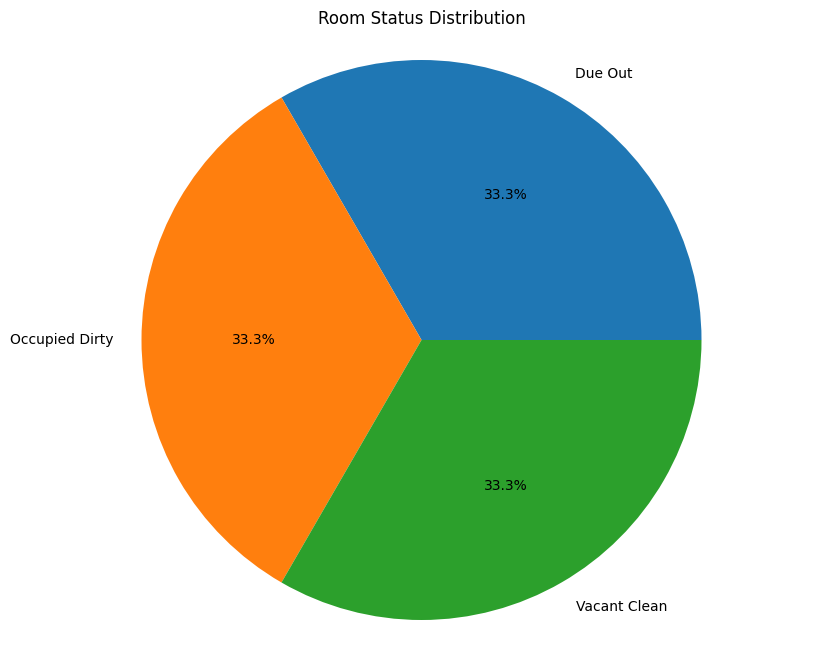


Staff Performance Report:


Name,Position,Performance Rating,Rooms Cleaned Today,Total Assignments,Average Cleaning Time (min)
John Doe,Housekeeper,4.5,0,0,None
Jane Smith,Supervisor,4.8,0,0,None
Mike Johnson,Housekeeper,4.2,0,0,None



Inventory Report:


Item Name,Quantity,Reorder Level,Unit Cost,Supplier,Category,Stock Status
Towels,100,50,5.99,LinenCo,Linens,Adequate Stock
Toiletries,200,100,2.99,SupplyCo,Amenities,Adequate Stock
Cleaning Solution,50,30,8.99,CleanCo,Cleaning,Adequate Stock



Generating Smart Assignments...
Room 101 assigned to staff ID 2
Room 102 assigned to staff ID 1


In [ ]:
from datetime import datetime, timedelta
from enum import Enum
import sqlite3
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

class RoomStatus(Enum):
    VACANT_CLEAN = "Vacant Clean"
    VACANT_DIRTY = "Vacant Dirty"
    OCCUPIED_CLEAN = "Occupied Clean"
    OCCUPIED_DIRTY = "Occupied Dirty"
    OUT_OF_ORDER = "Out of Order"
    DUE_OUT = "Due Out"

class Priority(Enum):
    HIGH = "High"
    MEDIUM = "Medium"
    LOW = "Low"

class HousekeepingSystem:
    def __init__(self, db_name=":memory:"):  # Using in-memory database for Colab compatibility
        self.conn = sqlite3.connect(db_name)
        self.create_tables()

    def create_tables(self):
        cursor = self.conn.cursor()

        # Enhanced Rooms table with more fields
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS rooms (
            room_number TEXT PRIMARY KEY,
            room_type TEXT,
            status TEXT,
            last_cleaned DATETIME,
            floor INTEGER,
            max_occupancy INTEGER,
            rate FLOAT,
            notes TEXT,
            maintenance_status TEXT
        )''')

        # Enhanced Staff table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS staff (
            id INTEGER PRIMARY KEY,
            name TEXT,
            position TEXT,
            shift TEXT,
            contact TEXT,
            hiring_date DATE,
            performance_rating FLOAT,
            rooms_cleaned_today INTEGER DEFAULT 0,
            available BOOLEAN DEFAULT 1
        )''')

        # Enhanced Assignments table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS assignments (
            id INTEGER PRIMARY KEY,
            room_number TEXT,
            staff_id INTEGER,
            assignment_date DATE,
            start_time DATETIME,
            end_time DATETIME,
            status TEXT,
            priority TEXT,
            cleaning_duration INTEGER,
            quality_check_passed BOOLEAN,
            FOREIGN KEY (room_number) REFERENCES rooms (room_number),
            FOREIGN KEY (staff_id) REFERENCES staff (id)
        )''')

        # Enhanced Inventory table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS inventory (
            id INTEGER PRIMARY KEY,
            item_name TEXT,
            quantity INTEGER,
            reorder_level INTEGER,
            last_restocked DATE,
            unit_cost FLOAT,
            supplier TEXT,
            category TEXT,
            minimum_order_quantity INTEGER
        )''')

        # New Guest Requests table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS guest_requests (
            id INTEGER PRIMARY KEY,
            room_number TEXT,
            request_type TEXT,
            request_time DATETIME,
            status TEXT,
            priority TEXT,
            notes TEXT,
            assigned_staff_id INTEGER,
            completion_time DATETIME,
            FOREIGN KEY (room_number) REFERENCES rooms (room_number),
            FOREIGN KEY (assigned_staff_id) REFERENCES staff (id)
        )''')

        self.conn.commit()

    def add_room(self, room_number, room_type, floor, max_occupancy, rate, status=RoomStatus.VACANT_CLEAN.value):
        cursor = self.conn.cursor()
        cursor.execute('''
        INSERT INTO rooms (room_number, room_type, status, last_cleaned, floor, max_occupancy, rate, maintenance_status)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (room_number, room_type, status, datetime.now(), floor, max_occupancy, rate, "Good"))
        self.conn.commit()

    def update_room_status(self, room_number, new_status):
        """Update the status of a room"""
        cursor = self.conn.cursor()
        if isinstance(new_status, RoomStatus):
            status_value = new_status.value
        else:
            status_value = new_status

        cursor.execute('''
        UPDATE rooms
        SET status = ?,
            last_cleaned = CASE
                WHEN ? IN (?, ?) THEN DATETIME('now')
                ELSE last_cleaned
            END
        WHERE room_number = ?
        ''', (status_value, status_value,
              RoomStatus.VACANT_CLEAN.value,
              RoomStatus.OCCUPIED_CLEAN.value,
              room_number))
        self.conn.commit()

    def add_guest_request(self, room_number, request_type, priority, notes=""):
        cursor = self.conn.cursor()
        cursor.execute('''
        INSERT INTO guest_requests (room_number, request_type, request_time, status, priority, notes)
        VALUES (?, ?, ?, ?, ?, ?)
        ''', (room_number, request_type, datetime.now(), "Pending", priority, notes))
        self.conn.commit()

    def update_staff_performance(self, staff_id, performance_rating):
        cursor = self.conn.cursor()
        cursor.execute('''
        UPDATE staff
        SET performance_rating = ?,
            rooms_cleaned_today = rooms_cleaned_today + 1
        WHERE id = ?
        ''', (performance_rating, staff_id))
        self.conn.commit()

    def create_assignment(self, room_number, staff_id, priority=Priority.MEDIUM.value):
        """Create a new cleaning assignment"""
        cursor = self.conn.cursor()
        cursor.execute('''
        INSERT INTO assignments (
            room_number, staff_id, assignment_date, start_time,
            status, priority, cleaning_duration, quality_check_passed
        )
        VALUES (?, ?, DATE('now'), DATETIME('now'), ?, ?, 0, 0)
        ''', (room_number, staff_id, "Pending", priority))
        self.conn.commit()

    def get_current_shift(self):
        """Determine current shift based on time of day"""
        hour = datetime.now().hour
        if 7 <= hour < 15:
            return "Morning"
        elif 15 <= hour < 23:
            return "Evening"
        else:
            return "Night"

    def visualize_room_status(self):
        """Generate a pie chart of room statuses"""
        cursor = self.conn.cursor()
        cursor.execute('SELECT status, COUNT(*) FROM rooms GROUP BY status')
        data = cursor.fetchall()

        if not data:  # Check if there's data to visualize
            print("No room data available to visualize")
            return

        labels = [status for status, _ in data]
        sizes = [count for _, count in data]

        plt.figure(figsize=(10, 8))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%')
        plt.title('Room Status Distribution')
        plt.axis('equal')
        plt.show()

    def generate_staff_performance_report(self):
        """Generate a performance report for all staff members"""
        cursor = self.conn.cursor()
        cursor.execute('''
        SELECT
            s.name,
            s.position,
            s.performance_rating,
            s.rooms_cleaned_today,
            COUNT(a.id) as total_assignments,
            AVG(a.cleaning_duration) as avg_cleaning_time
        FROM staff s
        LEFT JOIN assignments a ON s.id = a.staff_id
        GROUP BY s.id
        ''')

        data = cursor.fetchall()
        if not data:  # Check if there's data to display
            print("No staff data available")
            return None

        columns = ['Name', 'Position', 'Performance Rating', 'Rooms Cleaned Today',
                  'Total Assignments', 'Average Cleaning Time (min)']
        df = pd.DataFrame(data, columns=columns)
        display(HTML(df.to_html(index=False)))
        return df

    def smart_assignment_algorithm(self):
        """Advanced algorithm for assigning rooms based on multiple factors"""
        cursor = self.conn.cursor()

        # Get available staff with their performance metrics
        cursor.execute('''
        SELECT id, performance_rating, rooms_cleaned_today
        FROM staff
        WHERE available = 1 AND shift = ?
        ''', (self.get_current_shift(),))
        available_staff = cursor.fetchall()

        # Get rooms needing cleaning with priority factors
        cursor.execute('''
        SELECT room_number, status, floor
        FROM rooms
        WHERE status IN (?, ?, ?)
        ''', (RoomStatus.VACANT_DIRTY.value,
              RoomStatus.OCCUPIED_DIRTY.value,
              RoomStatus.DUE_OUT.value))
        dirty_rooms = cursor.fetchall()

        if not available_staff or not dirty_rooms:
            return []

        assignments = []
        for room in dirty_rooms:
            if not available_staff:
                break

            # Calculate priority score for each staff member
            staff_scores = []
            for staff in available_staff:
                staff_id, performance, rooms_cleaned = staff
                score = (performance * 0.4 +  # 40% weight to performance
                        (1 - (rooms_cleaned / 10)) * 0.6)  # 60% weight to workload
                staff_scores.append((staff_id, score))

            # Assign to staff member with highest score
            best_staff = max(staff_scores, key=lambda x: x[1])
            priority = Priority.HIGH.value if room[1] == RoomStatus.DUE_OUT.value else Priority.MEDIUM.value

            self.create_assignment(room[0], best_staff[0], priority)
            assignments.append((room[0], best_staff[0]))

            # Update staff workload
            available_staff = [s for s in available_staff if s[0] != best_staff[0]]

        return assignments

    def generate_inventory_report(self):
        """Generate a detailed inventory report with reorder recommendations"""
        cursor = self.conn.cursor()
        cursor.execute('''
        SELECT
            item_name,
            quantity,
            reorder_level,
            unit_cost,
            supplier,
            category,
            CASE
                WHEN quantity <= reorder_level THEN 'Reorder Required'
                WHEN quantity <= reorder_level * 1.2 THEN 'Low Stock'
                ELSE 'Adequate Stock'
            END as stock_status
        FROM inventory
        ORDER BY stock_status DESC
        ''')

        data = cursor.fetchall()
        if not data:  # Check if there's data to display
            print("No inventory data available")
            return None

        columns = ['Item Name', 'Quantity', 'Reorder Level', 'Unit Cost',
                  'Supplier', 'Category', 'Stock Status']
        df = pd.DataFrame(data, columns=columns)
        display(HTML(df.to_html(index=False)))
        return df

    def close_connection(self):
        self.conn.close()

# Example usage for Google Colab
def main():
    # Create system instance
    system = HousekeepingSystem()

    # Add sample rooms
    system.add_room("101", "Single", 1, 2, 100.0)
    system.add_room("102", "Double", 1, 4, 150.0)
    system.add_room("201", "Suite", 2, 4, 250.0)

    # Add sample staff
    cursor = system.conn.cursor()
    cursor.execute('''
    INSERT INTO staff (name, position, shift, contact, hiring_date, performance_rating)
    VALUES
        ("John Doe", "Housekeeper", "Morning", "555-0101", "2023-01-01", 4.5),
        ("Jane Smith", "Supervisor", "Morning", "555-0102", "2023-02-01", 4.8),
        ("Mike Johnson", "Housekeeper", "Evening", "555-0103", "2023-03-01", 4.2)
    ''')
    system.conn.commit()

    # Add sample inventory
    cursor.execute('''
    INSERT INTO inventory (item_name, quantity, reorder_level, unit_cost, supplier, category, minimum_order_quantity)
    VALUES
        ("Towels", 100, 50, 5.99, "LinenCo", "Linens", 50),
        ("Toiletries", 200, 100, 2.99, "SupplyCo", "Amenities", 100),
        ("Cleaning Solution", 50, 30, 8.99, "CleanCo", "Cleaning", 20)
    ''')
    system.conn.commit()

    # Update some room statuses
    system.update_room_status("101", RoomStatus.OCCUPIED_DIRTY)
    system.update_room_status("102", RoomStatus.DUE_OUT)

    # Generate and display reports
    print("\nRoom Status Distribution:")
    system.visualize_room_status()

    print("\nStaff Performance Report:")
    system.generate_staff_performance_report()

    print("\nInventory Report:")
    system.generate_inventory_report()

    # Run smart assignment algorithm
    print("\nGenerating Smart Assignments...")
    assignments = system.smart_assignment_algorithm()
    for room, staff in assignments:
        print(f"Room {room} assigned to staff ID {staff}")

    system.close_connection()

if __name__ == "__main__":
    main()